[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/exercises/Ex08_forecasting_financial/Ex08b_Forecasting_fin_data.ipynb)

# Forecasting financial times series with LSTM

During the previous tutorial, you have learnt about RNNs and the LSTM, learnt something about the different types of LSTM (statefull, stateless, one to one, one to many, etc...)

Direct financial forecasting of times series with RNN family models still remains to reach its full potential.
At the moment, traditional statistical models like ARIMA and GARCH are often, at least, competitive to complex NN and LSTMs in particular. Do not expect great results when we apply LSTMs to stock prediction today. For illustration, we will try to develop a one-day ahead prediction of the Amazon stock (AMZN) using data of past stock movements. Feel very free to adapt the code to predict other stocks. 

Our target value will be the percentage return defined as 

$$r= \frac{x_{t+1}-x_{t}}{x_{t}}$$

**Remark:**<br>
Time series data is a specific form of sequential data, and stock data may be considered a special type of time series data. Applying a LSTM to stock prediction is a nontrivial task. The tutorial will involve parts to address the peculiarities of the example, which we picked because it is naturally interesting for business/econ people. A useful preparation or follow-up to this tutorial is to read the following blogs. Make sure to also run and debug the codes they develop.
1. [Solving Sequence Problems with LSTM in Keras - Part 1](https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/)
2. (Optional [Solving Sequence Problems with LSTM in Keras - Part 2](https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras-part-2/))
3. [ML Mastery: Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)
4.  [ML Mastery: Multi-step Time Series Forecasting with Long Short-Term Memory Networks in Python](https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/)
5.  [ML Mastery: Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)

**Disclaimer:**<br>
The contents of this tutorial are not financial advice or meant as a trading strategy. Remember that neural networks are flexible statistical models, not magic.

In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [53]:
data = pd.read_csv("../../data/AMZN.csv",sep=",") 
#data = pd.read_csv("../../data/TSPrep.csv",sep="\t") 
data.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
2759,2020-03-17,1775.469971,1857.780029,1689.239990,1807.839966,1807.839966,10917100
2760,2020-03-18,1750.000000,1841.660034,1745.000000,1830.000000,1830.000000,9645200
2761,2020-03-19,1860.000000,1945.000000,1832.650024,1880.930054,1880.930054,10399900
2762,2020-03-20,1926.310059,1957.000000,1820.729980,1846.089966,1846.089966,9817900
2763,2020-03-23,1827.750000,1919.400024,1812.000000,1902.829956,1902.829956,7808500
2764,2020-03-24,1951.500000,1955.000000,1900.339966,1940.099976,1940.099976,7147100
2765,2020-03-25,1920.689941,1950.260010,1885.780029,1885.839966,1885.839966,6479100
2766,2020-03-26,1902.000000,1956.489990,1889.290039,1955.489990,1955.489990,6221300
2767,2020-03-27,1930.859985,1939.790039,1899.920044,1900.099976,1900.099976,5387900
2768,2020-03-30,1922.829956,1973.630005,1912.339966,1963.949951,1963.949951,6115100


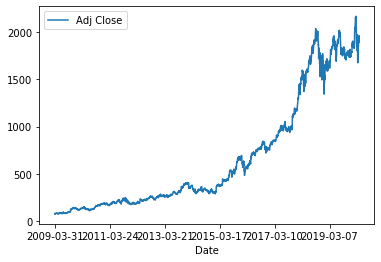

In [54]:
# We will only use Adj Close
ts= data.loc[:,["Date","Adj Close"]]
ts= ts.set_index('Date')
ts.plot();

It should be pointed out that LSTMs have shown an ability to capture patterns in unstationary data better than traditional models (after sufficient training).

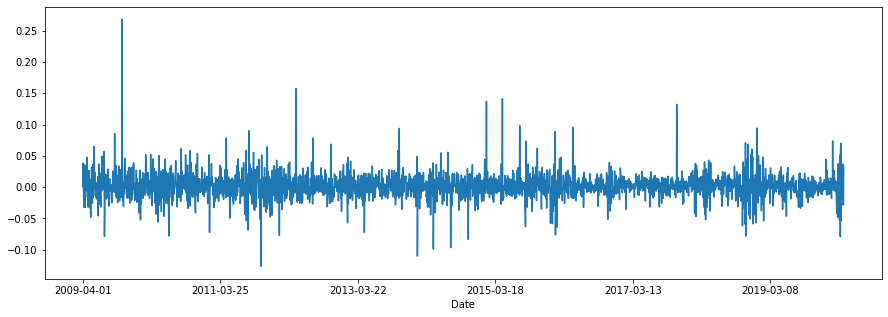

In [56]:
# Pandas knows a handy way to compute our return
ts['returns']=ts['Adj Close'].pct_change()

ret=ts['returns'].dropna()
ret.plot(figsize=(15, 5));

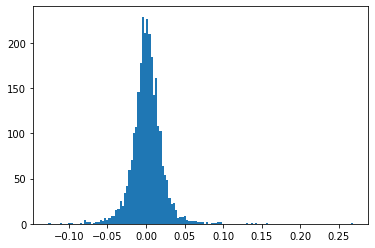

In [57]:
# Plot the distribution of returns
plt.hist(ret, bins='auto')  
plt.show()

Transform the pandas series into a numpy array once we're comfortable with the data and data processing. 

In [58]:
# Convert to numpy array
ret = ret.values
ret = ret.reshape(len(ret),1)
ret = ret.astype('float32')
print(ret.shape)
ret

(2768, 1)


array([[ 0.00081697],
       [ 0.0386394 ],
       [ 0.02397173],
       ...,
       [ 0.03693316],
       [-0.02832539],
       [ 0.03360348]], dtype=float32)

Split the data into a training and test set. We are using 80 percent of the data as training set and 20% as the test set. Remember not to sample randomly from different points in the time series! 

In [59]:
# Data partitining 
train_size  = int(len(ret) * 0.80)
test_size   = len(ret) - train_size
train, test = ret[:train_size], ret[train_size:]

Normalize the values to a range from 0 to 1. For time series, this is common since it doesn't require estimating the standard deviation/variance.

Remember to calculate summary statistics for data processing on the training data only!

In [60]:
# Scaling the data to the interval [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

Structure the data into convenient input and output for model training.

In [61]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

You can see that we will have to define the **timesteps** parameter, that is - how many steps back in time should be used to predict the target value. You can imagine that this hyperparameter can have quite an influence on the performance of your NN. Let's try to see if the partial autocorrelation plot can give us any hints.

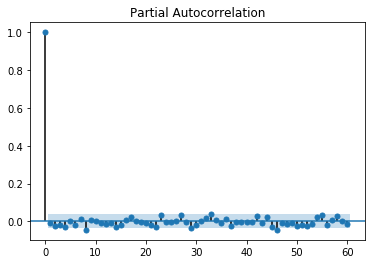

In [62]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ret, lags=60) # how many observations in time should be depicted
plt.show()

# To obtain the PACF values for further processing use
#sm.tsa.stattools.pacf(ret)

In this case, it is hard to grasp some particularly handy time span. Since we rather use a shorter time span, which will reduce computational cost, we select a value of 8. The PACF shows this lag to have an elevated effect. In general, past days with large, significant partial autocorrelation are the values to try out.

In [63]:
timesteps = 8 # parameter to tune, timesteps

# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
X_train.shape

(2206, 8, 1)

You might wonder whether we really need a customer function to create input data for machine learning models from a time series. Seems to be a standard task, right? Indeed, we could have made use of some functionality in, e.g., Keras to create our input data. The following example illustrates the use of the Keras *TimeseriesGenerator*, which provides corresponding functionality. We only demonstrate it for the training data. 

If you are interested in a more detailed discussion of how to create input data for machine learning models from time series check out [this ML mastery tutorial](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/).

In [64]:
from keras.preprocessing.sequence import TimeseriesGenerator

# Create input data from time series
demo = TimeseriesGenerator(train, train, length = timesteps, sampling_rate=1, batch_size=1)
print('Length of the output is {}.'.format(len(demo)))

# As result, we get a set of tuples (x, y) which we can enumerate and index
demo_x0 = demo[0][0]
demo_y0 = demo[0][1]
print(demo_x0)
print(X_train[0])   # Compare that to the above

# Likewise
print(demo_y0)
print(y_train[0])

# Here is an example to transform the output of TimeseriesGenerator to match the structure of X_train
demo_x = np.asarray([x[0] for x in demo])
print('Shape of demo_x {}'.format(demo_x.shape))
demo_x = np.reshape(demo_x, (len(demo), timesteps, 1))

# Confirm the two data structures are equivalent
print('Difference of the two data containers should be zero and evaluates to {}'.format(
    np.sum(demo_x - X_train)))


Length of the output is 2206.
[[[0.3228875 ]
  [0.4187572 ]
  [0.38157862]
  [0.31498006]
  [0.24021506]
  [0.37016195]
  [0.41268325]
  [0.29444322]]]
[[0.3228875 ]
 [0.4187572 ]
 [0.38157862]
 [0.31498006]
 [0.24021506]
 [0.37016195]
 [0.41268325]
 [0.29444322]]
[[0.2655882]]
[0.2655882]
Shape of demo_x (2206, 1, 8, 1)
Difference of the two data containers should be zero and evaluates to 0.0


According to Keras, expected input data shape: (number of observations/batch size (when stateful), timesteps, features (1=univariate, n=multivariate ts).


In [65]:
# Reshape input to be [obs, time steps, features]

X_train  = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test   = np.reshape(X_test,  (X_test.shape[0],  X_test.shape[1],  1))
print(X_train.shape,y_train.shape, X_test.shape,y_test.shape)


(2206, 8, 1) (2206, 1) (546, 8, 1) (546, 1)


Let's look at the first two observations and within each observation at the last 5 time steps. Notice how the values in the second observation are the observations of the first shifted by 1, with the first y now being the last observed value. 

In [15]:
X_train[0:2,-5:,:]

array([[[0.31498006],
        [0.24021506],
        [0.37016195],
        [0.41268325],
        [0.29444322]],

       [[0.24021506],
        [0.37016195],
        [0.41268325],
        [0.29444322],
        [0.2655882 ]]], dtype=float32)

In [16]:
y_train[0:2]

array([[0.2655882 ],
       [0.23842642]], dtype=float32)

### Evaluation and benchmark

For evaluation, we use **RMSE**. It penalizes large errors and the scores are easier to interpret as the units correspond to our target variable (return).

As for **benchmark** models, we will use a naive approach called the persistence forecast: next step is predicted according to the value of the previous step. To make the naïve benchmark as good as possible, we will not use the $t-1$ lag, but optimize the lag, so that $\hat{x}_{t} = x_{t-k}$ for the optimal $k$.

To implement the persistence benchmark, we make use of the code from a post at [MachineLearningMastery.com](https://machinelearningmastery.com/simple-time-series-forecasting-models/).

In [66]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

In [67]:
rmse_train = {}
rmse_test = {}

In [19]:
train.shape

(2214, 1)

p=1 RMSE:0.07660
p=2 RMSE:0.07248
p=3 RMSE:0.07291
p=4 RMSE:0.07344
p=5 RMSE:0.07080
p=6 RMSE:0.07350
p=7 RMSE:0.07180
p=8 RMSE:0.07924
p=9 RMSE:0.06991
p=10 RMSE:0.07354
p=11 RMSE:0.07397
p=12 RMSE:0.07136
p=13 RMSE:0.07095
p=14 RMSE:0.07340
p=15 RMSE:0.07103
p=16 RMSE:0.06987
p=17 RMSE:0.07048
p=18 RMSE:0.06899
p=19 RMSE:0.07194
p=20 RMSE:0.07116
p=21 RMSE:0.07203
p=22 RMSE:0.07050


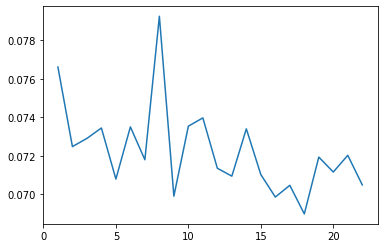

In [68]:
# Persistence code from machinelearningmastery.com/simple-time-series-forecasting-models/

persistence_values = range(1, 23) # how many days back (within a month) should we go as a forecast for tomorrow
scores = list()
for p in persistence_values:
    # walk-forward validation
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
    # make prediction
        yhat = history[-p]
        predictions.append(yhat)
    # observation
        history.append(test[i])
    # report performance
    error = rmse(test, predictions)
    scores.append(error)
    print('p=%d RMSE:%.5f' % (p, error))
# plot scores over persistence values
plt.plot(persistence_values, scores)
plt.show()

Judging from the plot, the lag $k=18$ seems to offer the best performance. Se we'll try that value. You can try other settings for practice or think of a more rigorous approach toward parameter selection. 

In [75]:
# Lag for the naive benchmark (i.e., persistence forecast)
k_naive = 18
# Since the persistenc forecasts looks at a past value of the time series, it is convenient to use the Pandas function shift()
# for calculating the benchmark. So we first collect the actual time series in a data frame,
pred_naive = pd.DataFrame(np.vstack([y_train, y_test]))
# and then use shift with our selected lag k_naive, while filling up NaN values at the beginning of the time series with the mean.
# Since we will never use the start of the time series (i.e., first samples in the training set) for testing, the mean replacement does 
# not affect subsequent results. 
pred_naive = pred_naive.shift(periods=k_naive, axis=0, fill_value=np.mean(y_train)).values

It is good practice to collect relevant variables and results in one data structure. This ensures that we have all the data we need in one place. We will create a dictionary in which we store the true realizations of our target variable (i.e., daily price differences) and the predictions of various models. This will make it easy to compare different models later on.

Further, to easy the interpretations of error values, it is preferable to reverse the scaling of the time series. For example, this allows us to interpret a root mean squared-error value as a deviation between the actual price difference and our forecast. Should we consider trading on our model - and you should not consider trading on any mode we build today, we would want to examine actual deviations as opposed to deviations between scaled variables. Reversing a scaling is very easy with scikit-learn.

In [76]:
# We use one dictionary for the training and one for the test data
pred_test = {}
pred_train = {}

# We store the actual price differences as opposed to their scaled version
pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 

# Also add the lagged persistence forecast
pred_train["naive"] = scaler.inverse_transform(pred_naive[:len(y_train), :]).flatten()  # This is a good example of why the [a, b-1] 
pred_test["naive"]  = scaler.inverse_transform(pred_naive[len(y_train):, :]).flatten()  # indexing is convenient

Let's plot predictions and actuals for illustration. To that end, it is nice that we can easily convert our dictionary into a data frame and use the corresponding plotting routines.

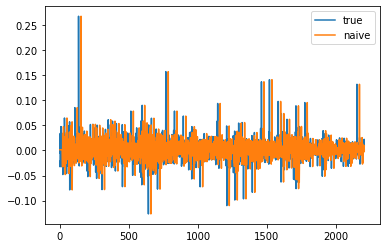

In [77]:
pd.DataFrame(pred_train).plot()
plt.show()

Calculate the RMSE of the naive model as a first indication.

In [78]:
rmse_train["naive"] = rmse(pred_train["true"], pred_train["naive"])
rmse_test["naive"]  = rmse(pred_test["true"],  pred_test["naive"])

rmse_test

{'naive': 0.027112652}

## LSTM in Keras 

In [79]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

This is the first time we use Keras for developing a LSTM. Instead of using a **dense** layer, we will make use of the **LSTM** layer. This layer offers us many design choices, including:

Design choices:
 - number of nodes (size of the hidden state, i.e. latent state dimensions, output size of the forget gate and input gate)
 - activation="tanh" - default
 - recurrent_activation="hard_sigmoid" - default. The 'hard' sigmoid is a faster, piecewise linear approximation of the smooth sigmoid function
 - kernel_initializer - as per your choice
 
Data handling:
 - input shape
 - return_sequences=False (the LSTM cell provides output from the last time step. If *True*, LSTM returns all of the outputs from the unrolled LSTM cell through time). Mind that the output of the LSTM layer is (obs or batch size/ time steps/ hidden size, so when return_sequence=False, we get only one result from the last time step, meaning that the output dimension is obs or batch size / hidden size). If you want to add more layers, you must set return_sequences to true, which will result in the layer returning a 3D tensor instead of a 2D matrix.
 - stateful=True (as discussed - do we want to keep the hidden states from batch to batch)
 - shuffle=False (we are trying to keep the order, in case using stateless can be set to True)

Various:
  - return_state=True/False (whether to return the last state in addition to output, 2 additional tensors)
  
Many of these arguments are crucial and have far-reaching implications. Setting up a LSTM for time series data or sequence data in general is not trivial. We will start with a simple case and incrementally add complexity. Nonetheless, you should have a look at more tutorials and demos to better understand what is going on. Here is a set of informative posts:


- [How to Reshape Input Data for Long Short-Term Memory Networks in Keras](https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/)
- [How to Prepare Univariate Time Series Data for Long Short-Term Memory Networks](https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/)
- [Stateful LSTM in Keras](http://philipperemy.github.io/keras-stateful-lstm/)
-[Stateful and Stateless LSTM for Time Series Forecasting with Python](https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/)
- [How to use a stateful LSTM model, stateful vs stateless LSTM performance comparison](https://keras.io/examples/lstm_stateful/)
- [Difference Between Return Sequences and Return States for LSTMs in Keras](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/)
- [How to Prepare Sequence Prediction for Truncated BPTT in Keras](https://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/)

### Stateless LSTM
Let's not worry too much for start and just define and train a first LSTM.

In [80]:
X_train.shape

(2206, 8, 1)

In [83]:
# Define the model
batch_size = 32 # An arbitrary choice
stateless = Sequential()
stateless.add(LSTM(7))  # size of the LSTM hidden state, we select 7 units; also arbitrary 
stateless.add(Dense(1))
stateless.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

# Training
stateless.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_split=0.3, verbose=1)
stateless.summary()

Train on 1544 samples, validate on 662 samples
Epoch 1/10
1544/1544 [==============================] - 1s 644us/step - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/10
1544/1544 [==============================] - 0s 275us/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 3/10
1544/1544 [==============================] - 1s 359us/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 4/10
1544/1544 [==============================] - 0s 320us/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 5/10
1544/1544 [==============================] - 0s 320us/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 6/10
1544/1544 [==============================] - 1s 356us/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 7/10
1544/1544 [==============================] - 1s 364us/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0019 - val_mse: 0.0019
E

We can use this trained network for prediction; provided we remember to comply with the input data requirements.

In [84]:
# Input data for prediction as 3d array [samples / time steps / features]
stateless.predict(X_test[0].reshape(1, timesteps, 1))

array([[0.3278118]], dtype=float32)

In [85]:
# Compare to actual
y_test[0]

array([0.34907383], dtype=float32)

Let's try out one of the arguments of the LSTM layer, the *return_sequences* argument. As said, it should allow us to obtain LSTM outputs, predictions, for each processing step. Note that we will not train the new model now (for simplicity). This means that forecasts will result from random weights. The purpose of the demo is to sketch what happens if setting *return_sequences* to True.

In [86]:
# Define the model
demo = Sequential()
demo.add(LSTM(7, return_sequences=True))
demo.add(Dense(1))

demo.predict(X_test[0].reshape(-1, timesteps, 1))

array([[[0.02756987],
        [0.04934713],
        [0.06562205],
        [0.08277449],
        [0.09561376],
        [0.09760716],
        [0.10207202],
        [0.10599469]]], dtype=float32)

In [87]:
timesteps

8

If we try training the demo LSTM as above we get an error because our labels are not in the right format for training with return_sequences equal to True. That makes sense because y_train is currently an array of dimension (sample size, target value) while we would need target values for each time step. Here is a little demo to sketch what we need but please note that we only replicate y values for simplicity. This is not sensible! We would need to revisit out data organization and create a proper target label to really train our LSTM for such a multi-step forecasting setting. Read this post if you want to explore [multi-step forecasting using LSTMs](https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/). 

In [88]:
# Silly (!) copying of y values to showcase how target values would need to be organized
tmp_y  = np.repeat(y_train, timesteps, axis=1).reshape(-1, timesteps, 1)
demo.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])
# Training
demo.fit(X_train, tmp_y, batch_size=batch_size, epochs=10, validation_split=0.3, verbose=0)

Back to our first proper LSTM. We compute train and test set forecasts and store these for later comparisons.

In [89]:
# Remember that we need to reverse the scaling. This is equivalent to the above code for the persistence benchmark
pred_train["stateless"] = scaler.inverse_transform(
                              stateless.predict(X_train,verbose=0)
).flatten()

pred_test["stateless"] = scaler.inverse_transform(
stateless.predict(X_test,verbose=0)
).flatten()

Let's also compute the RMSE of our LSTM and create the same plot of forecasts and actuals that we produced above for the Persistence benchmark.

Train Score of stateless LSTM: 0.020953 RMSE
Test Score of stateless LSTM:  0.020769 RMSE


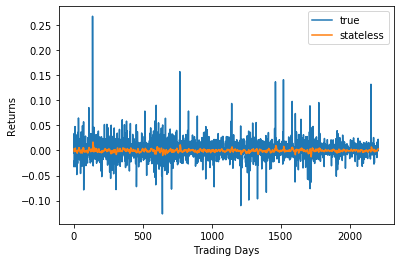

In [90]:
# Compute RMSE
rmse_train["stateless"] = rmse(pred_train["true"], pred_train["stateless"])
rmse_test["stateless"]  = rmse(pred_test["true"],  pred_test["stateless"])

print('Train Score of stateless LSTM: %.6f RMSE' % (rmse_train["stateless"]))
print('Test Score of stateless LSTM:  %.6f RMSE' % (rmse_test["stateless"]))

# Plot actuals and forecasts
pd.DataFrame(pred_train)[["true","stateless"]].plot()
plt.xlabel('Trading Days')
plt.ylabel('Returns')
plt.show()

It is always wise to also examine predictions at a lower scale.

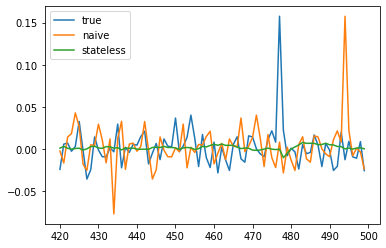

In [205]:
pd.DataFrame(pred_train).iloc[420:500,:].plot();

### Multiple layers
We discussed stacked LSTMs in the lecture. For this univariate time series, it is questionable whether a stacked LSTM does any better than one with only one LSTM layer. For example, [Fischer and Kraus (2019)](https://www.sciencedirect.com/science/article/abs/pii/S0377221717310652?via%3Dihub) report some very nice results from forecasting all stocks of the S&P 500 using a relatively simple LSTM. Nonetheless, developing stacked LSTMs using Keras is illustrative to better understand the way we need to input data and configure the network. Hence, let's build a network with two LSTM layers. 

In [91]:
stateless_multilayer = Sequential()
stateless_multilayer.add(LSTM(7, return_sequences=True))
#stateless_multilayer.add(Dropout(0.2))  # you can also add dropout layers if you like
stateless_multilayer.add(LSTM(7, return_sequences=False))
#stateless_multilayer.add(Dropout(0.2))
stateless_multilayer.add(Dense(1))
stateless_multilayer.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

Make sure to examine the above architecture carefully. The first layer uses *return_sequences=True*. Hence, we get one output value for each time step. These outputs can then be used as input for the second LSTM layer. This is the only way to do it. If you want to develop a stacked LSTM, you have to use *return_sequences=True* to get an input for the second layer; same when you make your network deeper and add more layers. The output of one layer is the input of the next layer.

Also note how we set *return_sequences=False* in the top layer. This means that we only get one forecast for the target variable from the last hidden state after processing the full sequence. Therefore, we do not need to adjust our target in any way and can train right with the 2d array *y_train* as follows. 

In [93]:
y_train.shape

(2206, 1)

In [92]:
stateless_multilayer.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_split=0.3);

Train on 1544 samples, validate on 662 samples
Epoch 1/10
1544/1544 [==============================] - 2s 1ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 2/10
1544/1544 [==============================] - 0s 308us/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 3/10
1544/1544 [==============================] - 1s 387us/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 4/10
1544/1544 [==============================] - 1s 374us/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 5/10
1544/1544 [==============================] - 1s 436us/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 6/10
1544/1544 [==============================] - 1s 403us/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 7/10
1544/1544 [==============================] - 1s 399us/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0019 - val_mse: 0.0019
Epo

To complete the part on the stacked LSTM, we proceed as above to produce some error metrics and a plot.

Train Score: 0.020961 RMSE
Test Score: 0.020870 RMSE


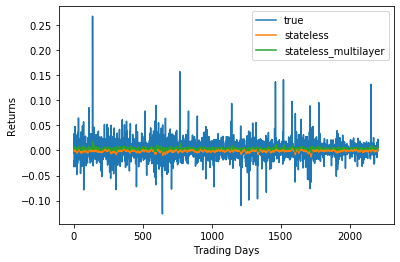

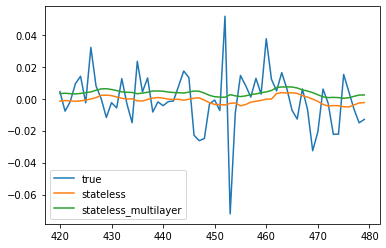

In [94]:
# Error assessment of the stacked LSTM
pred_train["stateless_multilayer"] = scaler.inverse_transform(
                              stateless_multilayer.predict(X_train,verbose=0)
).flatten()

pred_test["stateless_multilayer"] = scaler.inverse_transform(
                              stateless_multilayer.predict(X_test,verbose=0)
).flatten()

rmse_train["stateless_multilayer"] = rmse(pred_train["true"], pred_train["stateless_multilayer"])
rmse_test["stateless_multilayer"] = rmse(pred_test["true"], pred_test["stateless_multilayer"])

print('Train Score: %.6f RMSE' % (rmse_train["stateless_multilayer"]))
print('Test Score: %.6f RMSE' % (rmse_test["stateless_multilayer"]))

# Plot of forecasts and actuals
pd.DataFrame(pred_train)[["true","stateless","stateless_multilayer"]].plot()
plt.xlabel('Trading Days')
plt.ylabel('Returns')
plt.show()

# and again for a specific time interval 
pd.DataFrame(pred_train)[["true","stateless","stateless_multilayer"]].iloc[420:480,:].plot()
plt.show()

In [95]:
print(rmse_train)
print(rmse_test)

{'naive': 0.029192997, 'stateless': 0.020953441, 'stateless_multilayer': 0.020961}
{'naive': 0.027112652, 'stateless': 0.020769149, 'stateless_multilayer': 0.020870065}


### Stateful LSTM

Stateful LSTM training enables us to forward the hidden state through all time steps. Note that we don't send the gradient back over all time steps and make sure you understand the difference. An LSTM with >1000 time steps is a very deep network when unrolled. On the other hand, a network that propagates the error back 20 time steps is reasonable shallow, but can be initialized with the state after 1000 time steps. 

When enabling stateful training, we need to manange the transition between observations correctly. If we don't, we will start a sequence with the hidden state at another period of time! 

Remember that this is what our data looks like. For the sake of the visualization, we'll go with a small window size of 4 but leave the batch size to be determined. 

<img src="time_series_structure.png" alt="time series data structure" style="width: 600px;"/>

Now let's assume a batch size of 1, the smallest possible, and see what happens during training:

<img src="batch_size_1.png" alt="batch_size_1_wrong" style="width: 600px;"/>

We update the hidden state with the first four inputs $x_0, x_1, x_2, x_3$. We then use the last hidden state, $h_3$, to make a prediction for the next period. So far, the procedure is identical to the stateless RNN. 

We initialize the hidden state for the next batch, $x_1, x_2, x_3, x_4$, not with zeros but with the hidden state from the last batch, $h_3$. Oh no, that doesn't look right! We would like to start with the hidden state after the first period, $h_0$, instead we are starting with $h_3$!

Well, what would we need to change to start with $h_0$ before we process input $x_1$? What about starting with $h_1$ before we process $x_2$? We have control over three things: The window size, the batch size and the structure of the data. 

We determined the window size empirically, so we might not want to change it arbitrarily.
However, we could change the batch size! Try different batch sizes and you'll see that for the way we structured the data, the state forwarding works as expected when the batch size is equal to the window size. Note in particular that the state for the n-th observation in a batch is transferred to the n-th observation in the next batch. 

<img src="batch_size_4.png" alt="batch_size_equal_window_size_right" style="width: 600px;"/>

That's what we will do today. But see how we recalculate a lot of the same hidden states within each batch? Could we avoid that? Indeed you could make a prediction at each time step (many-to-many architecture). Draw a picture and implement that at home! Be careful to adjust the data structure accordingly, so that the hidden state gets passed on correctly. 

In [96]:
batch_size = timesteps

For `stateful=True` you need to specify the batch size as part of the input shape. This is a Keras-specific implementation detail. 

In [97]:
stateful = Sequential()
stateful.add(LSTM(7,stateful=True, batch_input_shape=(batch_size, timesteps, 1), ))# if stateful, batch size has to be specified instead of input shape
stateful.add(Dense(1))
stateful.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

If you complete the image of the batch ordering until the end of the data, you'll notice that the last batch might be smaller than previous batches. Why? Because if the data is not equally divisible, we'll have some observations left over at the very end. Normally, that's not a problem and we work with a smaller batch at the end of each epoch. However, the stateful implementation requires us to specify and fix the batch size before training. 

To fix this issue, we will drop observations from the start of the time series until the data is nicely devisible into equal size batches. 

In [98]:
# The modulo % is the remainder after devision
rest = len(y_train) % batch_size
rest

6

In [99]:
X_train, y_train = X_train[rest:,:], y_train[rest:,:]

In [100]:
len(y_train) % batch_size

0

##### Training 

We'll use a custom training loop over epochs to reset the hidden states manually after each epoch.

In [101]:
for i in range(10):
    stateful.fit(X_train, y_train, batch_size=batch_size, epochs=1,
          #validation_split=0.3, # We cannot afford validation data to be sampled automatically as this would break the data ordering 
          shuffle=False) # don't shuffle, we must keep the order of observations for the batches to match
    stateful.reset_states()

Epoch 1/1
2200/2200 [==============================] - 2s 1ms/step - loss: 0.0078 - mse: 0.0078
Epoch 1/1
2200/2200 [==============================] - 2s 934us/step - loss: 0.0028 - mse: 0.0028
Epoch 1/1
2200/2200 [==============================] - 2s 974us/step - loss: 0.0028 - mse: 0.0028
Epoch 1/1
2200/2200 [==============================] - 2s 1ms/step - loss: 0.0028 - mse: 0.0028
Epoch 1/1
2200/2200 [==============================] - 2s 1ms/step - loss: 0.0028 - mse: 0.0028
Epoch 1/1
2200/2200 [==============================] - 2s 910us/step - loss: 0.0028 - mse: 0.0028
Epoch 1/1
2200/2200 [==============================] - 2s 696us/step - loss: 0.0028 - mse: 0.0028
Epoch 1/1
2200/2200 [==============================] - 2s 1ms/step - loss: 0.0028 - mse: 0.0028
Epoch 1/1
2200/2200 [==============================] - 2s 775us/step - loss: 0.0028 - mse: 0.0028
Epoch 1/1
2200/2200 [==============================] - 2s 786us/step - loss: 0.0028 - mse: 0.0028 1s - los


##### Prediction

We additionally need to ensure the divisibility of the test data. Since we don't want to drop test set observations, we will add training observations to build up the hidden state before the observations in the test data. 

In [102]:
X_test_extended = np.vstack([X_train, X_test])

In [103]:
# Drop early observations to accomodate batch size
X_test_extended = X_test_extended[(X_test_extended.shape[0] % batch_size):,:]

In [104]:
X_test_extended.shape[0] % batch_size

0

In [105]:
# Performance evaluation is ALMOST as usual 
pred_train["stateful"] = scaler.inverse_transform(
                              stateful.predict(X_train,verbose=0, batch_size=batch_size)
).flatten()

# However, there is one important bit
stateful.reset_states()

Why do we need to reset_states()? Having set `stateful=True`, the model will never reset its state automatically. 

Have a look at the hidden state after resetting and after making predictions below:

In [106]:
hidden_state = [keras.backend.get_value(s) for s, _ in stateful.state_updates]
print('Dim of the hidden state {}'.format(np.array(hidden_state).shape))
hidden_state

Dim of the hidden state (2, 8, 7)


[array([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]

In [107]:
pred_test_extended = stateful.predict(X_test_extended, verbose=0, batch_size=batch_size)

pred_test["stateful"] = scaler.inverse_transform(
                              pred_test_extended[-len(y_test):]
).flatten()

# Collect the hidden states before resetting them
state_before_reset = [keras.backend.get_value(s) for s, _ in stateful.state_updates]
state_before_reset
#stateful.reset_states()

[array([[-0.32416707,  0.28398848, -0.05048683,  0.07700842,  0.3129438 ,
         -0.44684032,  0.02631727],
        [-0.33519638,  0.28882667, -0.0504894 ,  0.07684424,  0.31714135,
         -0.44683293,  0.02925242],
        [-0.32452202,  0.27787167, -0.04570713,  0.07722865,  0.31598753,
         -0.44932503,  0.02340628],
        [-0.33842427,  0.28751704, -0.04818325,  0.07699981,  0.31974012,
         -0.4472189 ,  0.02725451],
        [-0.34315392,  0.2872789 , -0.04741379,  0.07738812,  0.32156262,
         -0.44851923,  0.02815839],
        [-0.32742175,  0.27484766, -0.04276778,  0.07795961,  0.31894135,
         -0.45066732,  0.02053256],
        [-0.3437486 ,  0.28787962, -0.0469152 ,  0.07772587,  0.32258752,
         -0.44762254,  0.02590538],
        [-0.32691398,  0.2737453 , -0.04228394,  0.07851136,  0.31914747,
         -0.45086724,  0.01880637]], dtype=float32),
 array([[-0.60598415,  0.56966704, -0.10267116,  0.16461615,  0.69118726,
         -1.4979371 ,  0.0646

The RMSE on the train data is slightly distorted, since we dropped some observations from `X_train` to adjust the number of observations to the batch size. Since we drop very few observations, let's assume that the distortion is small. 

In [112]:
rmse_train["stateful"] = rmse(pred_train["true"][:-rest], pred_train["stateful"])
print('Train Score: %.6f RMSE' % (rmse_train["stateful"]))
rmse_test["stateful"] = rmse(pred_test["true"], pred_test["stateful"])
print('Test Score: %.6f RMSE' % (rmse_test["stateful"]))

Train Score: 0.020606 RMSE
Test Score: 0.020672 RMSE


In [113]:
rmse_test

{'naive': 0.027112652,
 'stateless': 0.020769149,
 'stateless_multilayer': 0.020870065,
 'stateful': 0.020671826}

Since the stateful network doesn't predict on the full training data, we'll use a workaround to look at the graphs for the training set.

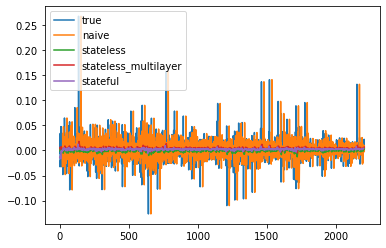

In [114]:
for model, x in pred_train.items():
    plt.plot(list(range(len(x))), x, label=model)
plt.legend()
plt.show()

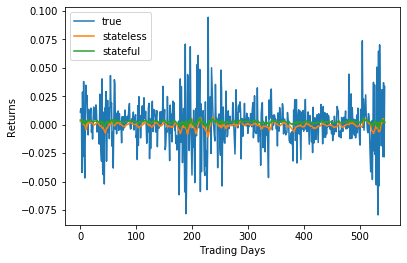

In [115]:
pd.DataFrame(pred_test)[["true","stateless","stateful"]].plot()
plt.xlabel('Trading Days')
plt.ylabel('Returns')
plt.show()

And a closer look at the beginning of the test set:

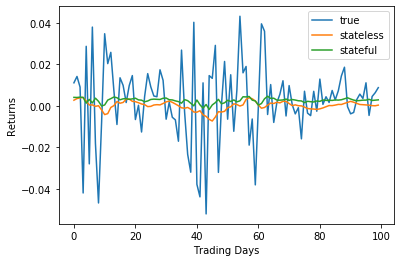

In [116]:
pd.DataFrame(pred_test)[["true","stateless","stateful"]].iloc[0:100,:].plot()
plt.xlabel('Trading Days')
plt.ylabel('Returns')
plt.show()

## Notes

### Predicting stocks

Predicting stock returns from their previous value only is a difficult problem. How difficult?

In [117]:
rmse_test["constant"] = rmse(pred_test["true"], np.zeros(len(pred_test["true"])))

In [118]:
rmse_test

{'naive': 0.027112652,
 'stateless': 0.020769149,
 'stateless_multilayer': 0.020870065,
 'stateful': 0.020671826,
 'constant': 0.020480202843202275}

### Predicting volatility 

Seems that it is very hard for the model to pick up this sort of oscillations. We could now try to predict the actual price or even better - the rolling volatility.

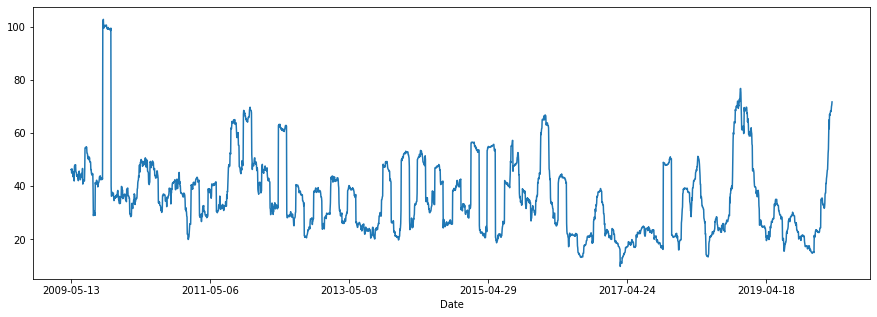

In [119]:
vola = ts['returns'].rolling(30).std() * np.sqrt(365) * 100
vola = vola.dropna()
vola.plot(figsize=(15, 5));

In [120]:
vola = vola.values
vola = vola.reshape(len(vola),1)
vola = vola.astype('float32')

# Split the data into a training (80%) and test set (20%)
train_size  = int(len(vola) * 0.80)
test_size   = len(vola) - train_size
train, test = vola[0:train_size], vola[train_size:len(vola)]

# Normalize the values to a range from 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)
train  = scaler.transform(train)
test   = scaler.transform(test)

In [121]:
# Reshape input to be [samples, time steps,features]
timesteps=30 # parameter to tune, timesteps

# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)#lookback
X_test, y_test    = create_dataset(test, timesteps)

X_train  = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_test   = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2161, 30, 1) (2161, 1) (518, 30, 1) (518, 1)


In [122]:
# Setup and train a stacked LSTM
batch_size = 32
model3 = Sequential()
model3.add(LSTM(20, return_sequences=True, input_shape=(timesteps, 1)))
model3.add(LSTM(20))
model3.add(Dense(1))
model3.compile(loss = 'mean_squared_error', optimizer = "adam",metrics=['mse'])

model3.fit(X_train, y_train,
          batch_size=batch_size, epochs=10,
          validation_split=0.3);


Train on 1512 samples, validate on 649 samples
Epoch 1/10
1512/1512 [==============================] - 3s 2ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 2/10
1512/1512 [==============================] - 2s 1ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 3/10
1512/1512 [==============================] - 2s 1ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/10
1512/1512 [==============================] - 2s 1ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 5/10
1512/1512 [==============================] - 3s 2ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 6/10
1512/1512 [==============================] - 2s 1ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 7/10
1512/1512 [==============================] - 2s 1ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 8/10
1512

In [123]:
# Calculate forecasts and accuracy
trainPredict3    = model3.predict(X_train,verbose=0)
testPredict3     = model3.predict(X_test,verbose=0)

trainPredict3    = scaler.inverse_transform(trainPredict3)
trainY3          = scaler.inverse_transform(y_train)
testPredict3     = scaler.inverse_transform(testPredict3)
testY3           = scaler.inverse_transform(y_test)

trainScore3 = rmse(trainY3, trainPredict3)
testScore3 = rmse(testY3, testPredict3)

print('Train Score: %.6f RMSE' % (trainScore3))
print('Test Score: %.6f RMSE' % (testScore3))


Train Score: 5.019295 RMSE
Test Score: 3.817698 RMSE


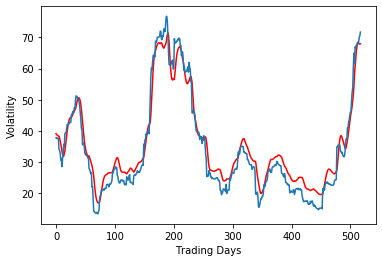

In [124]:
plt.plot(testPredict3, color="red")
plt.plot(testY3)
plt.xlabel('Trading Days')
plt.ylabel('Volatility')
plt.show()

In [286]:
# Persistnace forecast with lag of 1
testPredict_naive = pd.DataFrame(testY3).shift(periods=1, axis=0, fill_value=np.mean(trainY3)).values

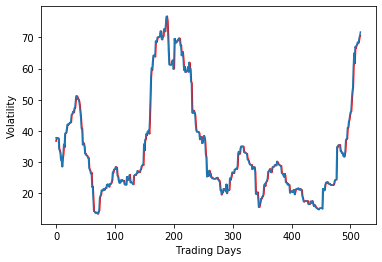

In [287]:
plt.plot(testPredict_naive, color="red")
plt.plot(testY3)
plt.xlabel('Trading Days')
plt.ylabel('Volatility')
plt.show()

In [288]:
testScore_naive = np.sqrt(mean_squared_error(testY3, testPredict_naive))
print('Test Score: %.6f RMSE' % (testScore_naive))

Test Score: 1.694813 RMSE


### Changing the batch size

Unfortunately, we would like to use a batch size of 1 for prediction in many applications, since we will have a single new observation each day and want to make a single's day prediction. Changing the batch size for a stateful network is not implemented in keras, so we could use a workaround.

We could create a new network with a different batch size and take the weights and biases over from the old network. See [this post for an extended demo](https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/) of this approach.

In [266]:
# Get weights
stateful_weights = stateful.get_weights()

In [267]:
# Create fresh model
stateful_forecaster = Sequential()
stateful_forecaster.add(LSTM(7,stateful=True, batch_input_shape=(1, # <--- Batch size is now 1 
                                                      timesteps, 1), ))
stateful_forecaster.add(Dense(1))
#stateful_forecaster.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [268]:
stateful_forecaster.set_weights(stateful_weights)

Be careful that this may break the forwarding of the state to the next observation! 